In [1]:
from rasterio.plot import show
from rasterio.merge import merge
import rasterio as rio
from rasterio import features
import rioxarray

from pathlib import Path
import glob
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from PIL import Image

Zwischenspeichern des Raster Stacks auf der Festplatte. <br>
Da alle Raster-Dateien des Arbeitsgebietes die gleiche Ausdehnung haben, können sie einfach mit rasterio aufeinandergestackt werden.

In [2]:

def make_stack (path, file_string, appendix):
    #getall file paths from path
    #path = 'C:/Uni Jena/GEO 411/Data/Sentinel-2/NDVI_20m_arbeitsgebiete/Thueringen/'
    #file_string = "ND"
    file_list = glob.glob(path + file_string+'*.tiff')
    str_start = -13
    str_end = -5

    # Read metadata of first file
    with rio.open(file_list[0]) as src0:
        meta = src0.meta
        # mein Proj4 Pfad ist kaputt, deshalb hier der explizite Proj4 String
        meta.update({'crs': 'PROJCS["ETRS89 / UTM zone 32N",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.01745329251994328,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],AUTHORITY["EPSG","25832"],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'})

    # Update meta to reflect the number of layers
    meta.update(count = len(file_list))

    # Read each layer and write it to stack
    with rio.open(path + 'stack_' +appendix + '.tif', 'w', **meta) as dst:
        for id, layer in enumerate(file_list, start=1):
            with rio.open(layer) as src1:
                dst.write_band(id, src1.read(1))
                time = pd.to_datetime(layer[str_start:str_end], format='%Y%m%d')
                # speichere Zeitstempel in Band descriptions
                dst.set_band_description(id, str(time))


In [3]:
def reclassify(input_ds):
    for i in range(len(input_ds)):
        arr = input_ds[i].values
        arr[np.where(arr< 5)] = 0
        arr[np.where((arr> 5) & (arr <= 25))] = 1
        arr[np.where((arr> 25) & (arr <= 45))] = 2
        arr[np.where((arr> 45) & (arr <= 65))] = 3
        arr[np.where((arr> 65) & (arr <= 85))] = 4
        arr[np.where(arr> 85)] = 5
        input_ds[i] = arr
    return input_ds

In [4]:
#make_stack('C:/Uni Jena/GEO 411/Data/Sentinel-2/NDVI_20m_arbeitsgebiete/Thueringen/', 'ND', 'NDVI')

In [5]:
#make_stack('C:/Uni Jena/GEO 411/Data/Sentinel-2/NDWI_20m_arbeitsgebiete/Thueringen/', 'ND', 'NDWI')

In [6]:
#make_stack('C:/Uni Jena/GEO 411/Data/Sentinel-2/NDVI_20m_arbeitsgebiete/Thueringen/', 'SCL', 'SCL')

In [7]:
#make_stack('C:/Uni Jena/GEO 411/Data/Sentinel-2/NDVI_20m_arbeitsgebiete/Unterfranken/', 'ND', 'NDVI')

In [8]:
#make_stack('C:/Uni Jena/GEO 411/Data/Sentinel-2/NDWI_20m_arbeitsgebiete/Unterfranken/', 'ND', 'NDWI')

In [9]:
#make_stack('C:/Uni Jena/GEO 411/Data/Sentinel-2/NDVI_20m_arbeitsgebiete/Unterfranken/', 'SCL', 'SCL')

In [10]:
'''
# check GDAL
from osgeo import gdal
import matplotlib.pyplot as plt

dataset = gdal.Open('C:/Uni Jena/GEO 411/Data/Sentinel-2/NDVI_20m_arbeitsgebiete/Thueringen/stack.tif')
b1 = dataset.GetRasterBand(1).ReadAsArray()
f = plt.figure()
plt.imshow(b1)
plt.show()
dataset = None
'''

"\n# check GDAL\nfrom osgeo import gdal\nimport matplotlib.pyplot as plt\n\ndataset = gdal.Open('C:/Uni Jena/GEO 411/Data/Sentinel-2/NDVI_20m_arbeitsgebiete/Thueringen/stack.tif')\nb1 = dataset.GetRasterBand(1).ReadAsArray()\nf = plt.figure()\nplt.imshow(b1)\nplt.show()\ndataset = None\n"

In [11]:
ndvi_thueringen = rioxarray.open_rasterio('C:/Uni Jena/GEO 411/Data/Sentinel-2/NDVI_20m_arbeitsgebiete/Thueringen/stack_NDVI.tif')
ndwi_thueringen = rioxarray.open_rasterio('C:/Uni Jena/GEO 411/Data/Sentinel-2/NDWI_20m_arbeitsgebiete/Thueringen/stack_NDWI.tif')
SCL_thueringen = rioxarray.open_rasterio('C:/Uni Jena/GEO 411/Data/Sentinel-2/NDVI_20m_arbeitsgebiete/Thueringen/stack_SCL.tif')

ndvi_thueringen = ndvi_thueringen.assign_coords({"band": (pd.to_datetime(list(ndvi_thueringen.long_name)))})
ndwi_thueringen = ndwi_thueringen.assign_coords({"band": (pd.to_datetime(list(ndwi_thueringen.long_name)))})
SCL_thueringen = SCL_thueringen.assign_coords({"band": (pd.to_datetime(list(SCL_thueringen.long_name)))})

ndvi_thueringen.attrs['_FillValue'] = np.nan
ndwi_thueringen.attrs['_FillValue'] = np.nan

ndvi_thueringen.attrs['long_name'] = None
ndwi_thueringen.attrs['long_name'] = None
SCL_thueringen.attrs['long_name'] = None

In [12]:
ndvi_thueringen.band

<xarray.DataArray 'band' (band: 529)>
array(['2017-01-27T00:00:00.000000000', '2017-02-13T00:00:00.000000000',
       '2017-02-16T00:00:00.000000000', ..., '2023-06-17T00:00:00.000000000',
       '2023-06-18T00:00:00.000000000', '2023-06-22T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * band         (band) datetime64[ns] 2017-01-27 2017-02-13 ... 2023-06-22
    spatial_ref  int32 0

In [13]:
ndwi_thueringen

<xarray.DataArray (band: 529, y: 2799, x: 2438)>
[3609875898 values with dtype=float32]
Coordinates:
  * band         (band) datetime64[ns] 2017-01-27 2017-02-13 ... 2023-06-22
  * x            (x) float64 6.563e+05 6.563e+05 ... 7.051e+05 7.051e+05
  * y            (y) float64 5.673e+06 5.673e+06 ... 5.617e+06 5.617e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      None

In [14]:
SCL_thueringen

<xarray.DataArray (band: 529, y: 2799, x: 2438)>
[3609875898 values with dtype=uint8]
Coordinates:
  * band         (band) datetime64[ns] 2017-01-27 2017-02-13 ... 2023-06-22
  * x            (x) float64 6.563e+05 6.563e+05 ... 7.051e+05 7.051e+05
  * y            (y) float64 5.673e+06 5.673e+06 ... 5.617e+06 5.617e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      None

Das einzige, was bei dem oberen Datensatz nicht so schön ist, ist dass immer alle time stamps aus dem Attribut "long_name" angezeigt werden.
Ich hatte versucht, mit assin_coords() den einzelnen Arrays eine "time" zuzuordnen, aber das hat nur einmal funktioniert und dann wurde es einfach nicht mehr im xarray gespeichert...
Zur Not kann man aber immer die Position des bands im Stack mit der Position in dem long_name array gleichsetzen.

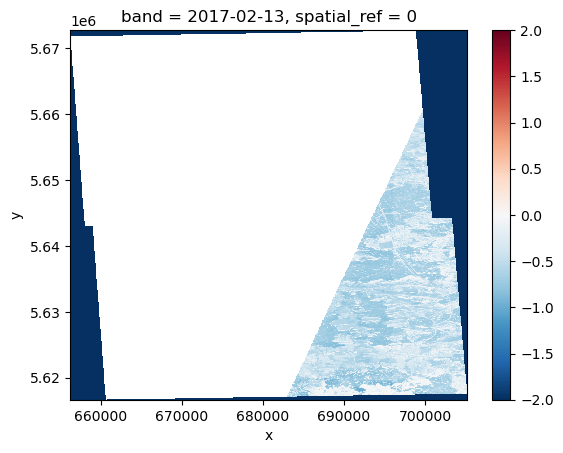

In [15]:
ndwi_thueringen[1].plot()

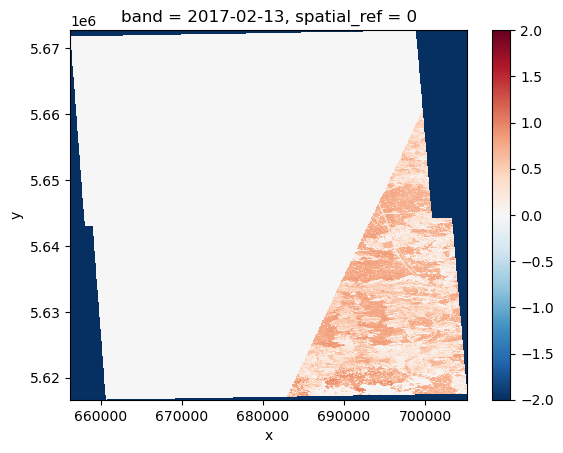

In [16]:
ndvi_thueringen[1].plot()

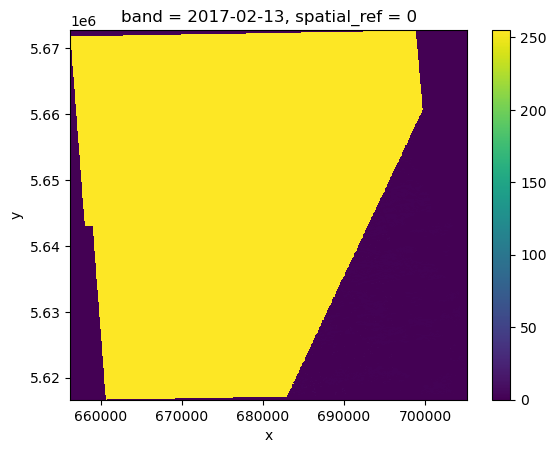

In [17]:
SCL_thueringen[1].plot()

In [18]:
#da.close()

In [19]:
'''
def make_sentinel_xarray(path, str_start, str_end, file_string):
    #path = 'C:/Uni Jena/GEO 411/Data/Radolan/Thueringen/'
    #getall file paths from path
    file_list = glob.glob(path + file_string+'*.tiff')

    # make empty list
    array_list = []
    
    for i in file_list:
        #open ds from filepath
        #da = xr.open_rasterio(i)
        da = rioxarray.open_rasterio(i)
        #convert date string from filename to timestamp
        time = pd.to_datetime(i[str_start:str_end], format='%Y%m%d')
        # assign timestamp value to variable time
        da = da.assign_coords({"time": (time)})
        #delete default variable band
        da = da.sel(band=1, drop=True)
        da = da.expand_dims(dim="time")
        #put array in list
        array_list.append(da)

    #concatenate arrays from list to one xarray    
    radolan_xr = xr.concat([array_list[x] for x in range(len(array_list))], dim = "time")
    return radolan_xr
'''

'\ndef make_sentinel_xarray(path, str_start, str_end, file_string):\n    #path = \'C:/Uni Jena/GEO 411/Data/Radolan/Thueringen/\'\n    #getall file paths from path\n    file_list = glob.glob(path + file_string+\'*.tiff\')\n\n    # make empty list\n    array_list = []\n    \n    for i in file_list:\n        #open ds from filepath\n        #da = xr.open_rasterio(i)\n        da = rioxarray.open_rasterio(i)\n        #convert date string from filename to timestamp\n        time = pd.to_datetime(i[str_start:str_end], format=\'%Y%m%d\')\n        # assign timestamp value to variable time\n        da = da.assign_coords({"time": (time)})\n        #delete default variable band\n        da = da.sel(band=1, drop=True)\n        da = da.expand_dims(dim="time")\n        #put array in list\n        array_list.append(da)\n\n    #concatenate arrays from list to one xarray    \n    radolan_xr = xr.concat([array_list[x] for x in range(len(array_list))], dim = "time")\n    return radolan_xr\n'

In [20]:
is_cloud = xr.where(((SCL_thueringen == 0) | 
                 (SCL_thueringen == 1) | 
                 (SCL_thueringen == 3) | 
                 (SCL_thueringen == 8) | 
                 (SCL_thueringen == 9) | 
                 (SCL_thueringen == 10) | 
                 (SCL_thueringen == 11) |
                 (SCL_thueringen == 255)), True, False)

#mask only cloud free
mask = xr.where((is_cloud == 0), True, False)
ndvi_thueringen = ndvi_thueringen.where(mask, np.nan)
ndwi_thueringen = ndwi_thueringen.where(mask, np.nan)

In [21]:
valid_obs_per_year = mask.resample(band='1Y').sum(dim='band')

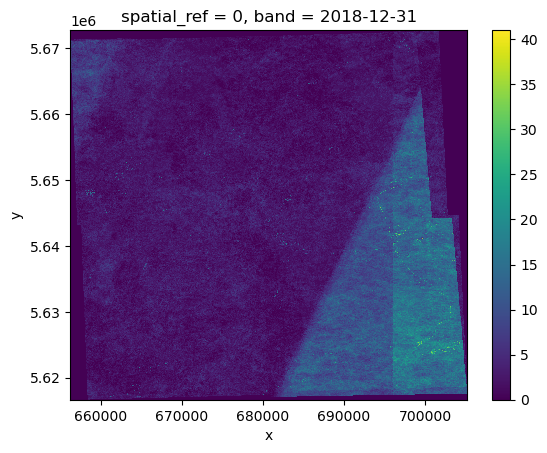

In [22]:
valid_obs_per_year[1].plot()

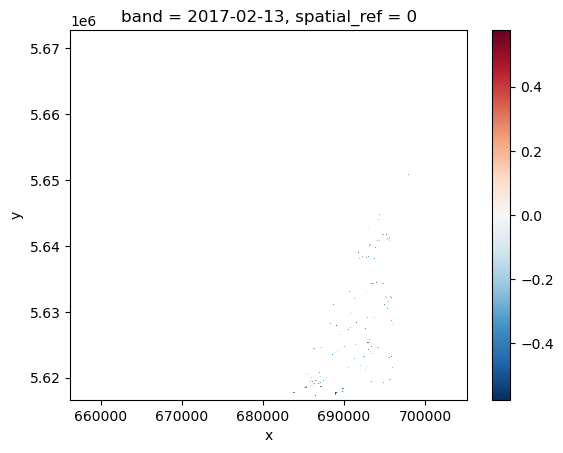

In [23]:
ndwi_thueringen[1].plot()

In [24]:
print(ndwi_thueringen.shape)
print(ndvi_thueringen.shape)
print(SCL_thueringen.shape)

(529, 2799, 2438)
(529, 2799, 2438)
(529, 2799, 2438)


In [25]:
np.unique(ndwi_thueringen)

array([-1.        , -0.9993458 , -0.99929076, ...,  0.99312717,
        1.        ,         nan], dtype=float32)

### Pfad unten anpassen mit Staunässe shapefile

In [26]:
geodf = gpd.read_file(r'C:\Uni Jena\GEO 411\Data\Feldgrenzen\thueringen_stauenaesse_bekannt.shp')
trocken = gpd.read_file(r'C:\Uni Jena\GEO 411\Data\Sentinel-2\maske.shp')

In [27]:
#get geometries of waterlogged fields
geodf = geodf[geodf['cat']=='staunaesse']
geodf = geodf.set_crs('epsg:25832', allow_override=True)
trocken = trocken.set_crs('epsg:25832', allow_override=True)
trocken = trocken.geometry

'''
stau0 = geodf[geodf['field_id']==0]
stau0 = stau0["geometry"].apply(lambda p: list(p.exterior.coords))[13]
stau1 = geodf[geodf['field_id']==1]
stau1 = stau1["geometry"].apply(lambda p: list(p.exterior.coords))[12]
stau2 = geodf[geodf['field_id']==2]
stau2 = stau2["geometry"].apply(lambda p: list(p.exterior.coords))[7]
stau3 = geodf[geodf['field_id']==3]
stau3 = stau3["geometry"].apply(lambda p: list(p.exterior.coords))[11]
stau4 = geodf[(geodf['field_id']==4)]
stau4_1 = stau4["geometry"].apply(lambda p: list(p.exterior.coords))[10]
stau4_2 = stau4["geometry"].apply(lambda p: list(p.exterior.coords))[15]
stau5 = geodf[geodf['field_id']==5]
stau5 = stau5["geometry"].apply(lambda p: list(p.exterior.coords))[8]
stau6 = geodf[geodf['field_id']==6]
stau6_1 = stau6["geometry"].apply(lambda p: list(p.exterior.coords))[9]
stau6_2 = stau6["geometry"].apply(lambda p: list(p.exterior.coords))[14]
'''


stau0 = geodf[geodf['field_id']==0].geometry
stau1 = geodf[geodf['field_id']==1].geometry
stau2 = geodf[geodf['field_id']==2].geometry
stau3 = geodf[geodf['field_id']==3].geometry
stau4 = geodf[geodf['field_id']==4].geometry
stau5 = geodf[geodf['field_id']==5].geometry
stau6 = geodf[geodf['field_id']==6].geometry


In [28]:
from pyproj import Transformer
from shapely.geometry import Polygon
transformer = Transformer.from_crs("EPSG:25832", "EPSG:4326")

def trans (liste):
    staux = []
    for i,j in liste:
        i,j = transformer.transform(i,j)
        t = (j,i)
        staux.append(t)
    clean_geoms = pd.DataFrame([["Polygon", staux]],
                           columns=["field_geom_type", "field_coords"])
    data = Polygon((clean_geoms.field_coords.iloc[0]))
    gdf = gpd.GeoSeries(data)
    return gdf

In [29]:
'''
staux0 = trans (stau0)
staux1 = trans (stau1)
staux2 = trans (stau2)
staux3 = trans (stau3)
staux4_1 = trans (stau4_1)
staux4_2 = trans (stau4_2)
staux4 = staux4_1.append(staux4_2)
staux5 = trans (stau5)
staux6_1 = trans (stau6_1)
staux6_2 = trans (stau6_2)
staux6 = staux6_1.append(staux6_2)
'''
staux = stau0.append([stau1,stau2,stau3,stau4, stau5, stau6])

C:\Users\apelt\anaconda3\envs\RADOLAN\lib\site-packages\geopandas\geoseries.py:622: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  val = getattr(super(), mtd)(*args, **kwargs)


In [30]:
#staux.to_file(r'C:\Uni Jena\GEO 411\plots\Sentinel_Karten\thueringen_staunaesse_reproj.shp')

In [31]:
#https://stackoverflow.com/questions/71015475/geopandas-polygon-coordinates-to-x-y-coordinate-columns

In [32]:
'''
clipped0 = ndwi_thueringen.rio.clip(staux0, all_touched=True)
clipped1 = ndwi_thueringen.rio.clip(staux1, all_touched=True)
clipped2 = ndwi_thueringen.rio.clip(staux2, all_touched=True)
clipped3 = ndwi_thueringen.rio.clip(staux3, all_touched=True)
clipped4 = ndwi_thueringen.rio.clip(staux4, all_touched=True)
clipped5 = ndwi_thueringen.rio.clip(staux5, all_touched=True)
clipped6 = ndwi_thueringen.rio.clip(staux6, all_touched=True)


clipped0_ndvi = ndvi_thueringen.rio.clip(staux0, all_touched=True)
clipped1_ndvi = ndvi_thueringen.rio.clip(staux1, all_touched=True)
clipped2_ndvi = ndvi_thueringen.rio.clip(staux2, all_touched=True)
clipped3_ndvi = ndvi_thueringen.rio.clip(staux3, all_touched=True)
clipped4_ndvi = ndvi_thueringen.rio.clip(staux4, all_touched=True)
clipped5_ndvi = ndvi_thueringen.rio.clip(staux5, all_touched=True)
clipped6_ndvi = ndvi_thueringen.rio.clip(staux6, all_touched=True)
'''
clipped_ndvi = ndvi_thueringen.rio.clip(staux, all_touched=True)
clipped_ndwi = ndwi_thueringen.rio.clip(staux, all_touched=True)

mask_clip = mask.rio.clip(staux, all_touched=True)

clipped_ndvi = clipped_ndvi.where(mask_clip, np.nan)
clipped_ndwi = clipped_ndwi.where(mask_clip, np.nan)

In [33]:
# group array by time
NDVI_groups = clipped_ndvi.groupby('band')
NDWI_groups = clipped_ndwi.groupby('band')

In [34]:
#Calculate timelines and return as lists for BSI and NDVI
NDVI_min = NDVI_groups.min(dim=["x", "y"], skipna=True)
NDVI_min = list(NDVI_min.values)
NDVI_max = NDVI_groups.max(dim=['x','y'], skipna=True)
NDVI_max = list(NDVI_max.values)
NDVI_quantiles = NDVI_groups.quantile([0.02, 0.05, 0.5, 0.95, 0.98], dim=['x','y'], skipna=True)
NDVI_quantiles = list(NDVI_quantiles)
NDVI_quantiles = [x.values for x in NDVI_quantiles]

NDVI_quant2 = [x[0] for x in NDVI_quantiles]
NDVI_quant5 = [x[1] for x in NDVI_quantiles]
NDVI_quant50 = [x[2] for x in NDVI_quantiles]
NDVI_quant95 = [x[3] for x in NDVI_quantiles]
NDVI_quant98 = [x[4] for x in NDVI_quantiles]
time_NDVI = [x for x in list(clipped_ndvi.groupby("band").groups)]

#write to dataframe
df_NDVI = pd.DataFrame()
df_NDVI['minimum']  = NDVI_min
df_NDVI['2% quantile']  = NDVI_quant2
df_NDVI['5% quantile']  = NDVI_quant5
df_NDVI['median']  = NDVI_quant50
df_NDVI['95% quantile']  = NDVI_quant95
df_NDVI['98% quantile']  = NDVI_quant98
df_NDVI['maximum']  = NDVI_max
df_NDVI['time']  = time_NDVI
df_NDVI.index = df_NDVI['time']
df_NDVI.to_csv('NDVI_statistics.csv')

C:\Users\apelt\anaconda3\envs\RADOLAN\lib\site-packages\numpy\lib\nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


In [35]:
df_NDVI

,minimum,2% quantile,5% quantile,median,95% quantile,98% quantile,maximum,time
time,,,,,,,,
2017-01-27,0.049923,0.131991,0.176780,0.486512,0.558660,0.569038,0.574934,2017-01-27
2017-02-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-02-13
2017-02-16,-0.113058,-0.016702,0.017468,0.137138,0.237143,0.255290,0.319199,2017-02-16
2017-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-28
2017-04-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-04-14
...,...,...,...,...,...,...,...,...
2023-06-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-06-13
2023-06-15,0.063574,0.075525,0.087847,0.501968,0.674249,0.687079,0.710354,2023-06-15
2023-06-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-06-17


In [36]:
#Calculate timelines and return as lists for BSI and NDVI
NDWI_min = NDWI_groups.min(dim=["x", "y"], skipna=True)
NDWI_min = list(NDWI_min.values)
NDWI_max = NDWI_groups.max(dim=['x','y'], skipna=True)
NDWI_max = list(NDWI_max.values)
NDWI_quantiles = NDWI_groups.quantile([0.02, 0.05, 0.5, 0.95, 0.98], dim=['x','y'], skipna=True)
NDWI_quantiles = list(NDWI_quantiles)
NDWI_quantiles = [x.values for x in NDWI_quantiles]

NDWI_quant2 = [x[0] for x in NDWI_quantiles]
NDWI_quant5 = [x[1] for x in NDWI_quantiles]
NDWI_quant50 = [x[2] for x in NDWI_quantiles]
NDWI_quant95 = [x[3] for x in NDWI_quantiles]
NDWI_quant98 = [x[4] for x in NDWI_quantiles]
time_NDWI = [x for x in list(clipped_ndwi.groupby("band").groups)]

#write to dataframe
df_NDWI = pd.DataFrame()
df_NDWI['minimum']  = NDWI_min
df_NDWI['2% quantile']  = NDWI_quant2
df_NDWI['5% quantile']  = NDWI_quant5
df_NDWI['median']  = NDWI_quant50
df_NDWI['95% quantile']  = NDWI_quant95
df_NDWI['98% quantile']  = NDWI_quant98
df_NDWI['maximum']  = NDWI_max
df_NDWI['time']  = time_NDWI
df_NDWI.index = df_NDWI['time']
df_NDWI.to_csv('NDWI_statistics.csv')

C:\Users\apelt\anaconda3\envs\RADOLAN\lib\site-packages\numpy\lib\nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


In [37]:
df_NDWI

,minimum,2% quantile,5% quantile,median,95% quantile,98% quantile,maximum,time
time,,,,,,,,
2017-01-27,-0.576355,-0.567188,-0.565868,-0.487924,-0.259515,-0.215670,-0.097659,2017-01-27
2017-02-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-02-13
2017-02-16,-0.171975,-0.166412,-0.160502,-0.117194,-0.066155,-0.052370,-0.040382,2017-02-16
2017-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-28
2017-04-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-04-14
...,...,...,...,...,...,...,...,...
2023-06-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-06-13
2023-06-15,-0.620387,-0.610607,-0.594585,-0.442857,-0.100336,-0.077415,-0.059937,2023-06-15
2023-06-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-06-17


In [38]:
print('NDVI 5%: ' ,df_NDVI['5% quantile'].mean())
print('NDWI 5%: ' ,df_NDWI['5% quantile'].mean())

print('NDVI 50%: ' ,df_NDVI['median'].mean())
print('NDWI 50%: ' ,df_NDWI['median'].mean())

print('NDVI 95%: ' ,df_NDVI['95% quantile'].mean())    
print('NDWI 95%: ' ,df_NDWI['95% quantile'].mean())

NDVI 5%:  0.13342051533309135
NDWI 5%:  -0.3422723221796332
NDVI 50%:  0.24946808479580795
NDWI 50%:  -0.24172958054259652
NDVI 95%:  0.3811984134314116
NDWI 95%:  -0.15644720810050786


In [39]:
df_stat_ndvi_mon = pd.DataFrame()
df_stat_ndvi_mon['median'] = df_NDVI.groupby(df_NDVI.index.month)['median'].mean()
df_stat_ndvi_mon['5%'] = df_NDVI.groupby(df_NDVI.index.month)['5% quantile'].mean()
df_stat_ndvi_mon['95%'] = df_NDVI.groupby(df_NDVI.index.month)['95% quantile'].mean()

#df_stat.index = df_stat.time
df_stat_ndvi_mon.to_csv('monthly_stat_NDVI.csv')

df_stat_ndwi_mon = pd.DataFrame()
df_stat_ndwi_mon['median'] = df_NDWI.groupby(df_NDWI.index.month)['median'].mean()
df_stat_ndwi_mon['5%'] = df_NDWI.groupby(df_NDWI.index.month)['5% quantile'].mean()
df_stat_ndwi_mon['95%'] = df_NDWI.groupby(df_NDWI.index.month)['95% quantile'].mean()

#df_stat.index = df_stat.time
df_stat_ndwi_mon.to_csv('monthly_stat_NDWI.csv')

In [40]:
df_stat_ndvi_mon

,median,5%,95%
time,,,
1,0.251258,0.128762,0.381072
2,0.223246,0.111663,0.343970
3,0.151567,-0.002213,0.336543
4,0.320596,0.155770,0.438734
5,0.365653,0.210684,0.528235
6,0.328405,0.142910,0.507208
7,0.167162,0.097942,0.261915
8,0.256164,0.178220,0.379535
9,0.157688,0.066295,0.268718


In [41]:
df_NDVI_sub = df_NDVI[(df_NDVI.index.month>=3) & (df_NDVI.index.month<=6)]
df_NDWI_sub = df_NDWI[(df_NDWI.index.month>=3) & (df_NDWI.index.month<=6)]

In [42]:
#classify data with given Thresholds, use float values for easier plotting
thuer_class_5 = xr.where((ndvi_thueringen <= df_NDVI_sub['5% quantile'].mean()) & 
                       (ndwi_thueringen >= df_NDWI_sub['95% quantile'].mean()), 1, 0)
thuer_class_median = xr.where((ndvi_thueringen <= df_NDVI_sub['median'].mean()) & 
                       (ndwi_thueringen >= df_NDWI_sub['median'].mean()), 1, 0)
thuer_class_95 = xr.where((ndvi_thueringen <= df_NDVI_sub['95% quantile'].mean()) & 
                       (ndwi_thueringen >= df_NDWI_sub['5% quantile'].mean()), 1, 0)

In [43]:
thuer_class_5 = thuer_class_5.resample(band='1Y').sum()
thuer_class_median = thuer_class_median.resample(band='1Y').sum()
thuer_class_95 = thuer_class_95.resample(band='1Y').sum()

In [44]:
thuer_class_5 = (thuer_class_5/valid_obs_per_year) *100
thuer_class_median = (thuer_class_median/valid_obs_per_year) *100
thuer_class_95 = (thuer_class_95/valid_obs_per_year) *100

In [45]:
thuer_class_5.rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/results/ThresholdMarJun_5quantile_yearlypercentage.tiff")
thuer_class_median.rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/results/ThresholdMarJun_50quantile_yearlypercentage.tiff")
thuer_class_95.rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/results/ThresholdMarJun_95quantile_yearlypercentage.tiff")

In [46]:
thuer_class_5_recl = reclassify(thuer_class_5)
thuer_class_median_recl = reclassify(thuer_class_median)
thuer_class_95_recl = reclassify(thuer_class_95)

In [47]:


thuer_class_5_recl.rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/results/ThresholdMarJun_5quantile_reclass.tiff")
thuer_class_median_recl.rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/results/ThresholdMarJun_50quantile_reclass.tiff")
thuer_class_95_recl.rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/results/ThresholdMarJun_95quantile_reclass.tiff")

In [48]:
thuer_class_5 = None
thuer_class_median = None
thuer_class_95 = None

thuer_class_5_recl = None
thuer_class_median_recl = None
thuer_class_95_recl = None

In [49]:
#valid_obs_per_year[1].plot()

In [50]:
#thuer_class_5[1].plot()
#print(np.unique(thuer_class_5[1], return_counts=True))

In [51]:
#pd.to_datetime(thuer_class_5.band)


In [52]:
#thuer_class_median[1].plot()

In [53]:
#thuer_class_95[1].plot()

In [54]:
# Use .groupby('time.month') to organize the data into months
# then use .groups to extract the indices for each month
month_idxs_ndvi=ndvi_thueringen.groupby('band.month').groups
month_idxs_ndvi = list(month_idxs_ndvi.values())

In [55]:
month_idxs_ndvi

[[0,
  45,
  46,
  47,
  162,
  163,
  164,
  165,
  249,
  250,
  251,
  252,
  253,
  338,
  339,
  404,
  405,
  406,
  407,
  408,
  409,
  499,
  500,
  501],
 [1,
  2,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  254,
  255,
  256,
  340,
  341,
  342,
  343,
  344,
  345,
  346,
  410,
  411,
  412,
  413,
  414,
  415,
  416,
  502,
  503,
  504,
  505,
  506,
  507],
 [3,
  56,
  57,
  58,
  59,
  60,
  61,
  173,
  174,
  175,
  176,
  257,
  258,
  259,
  260,
  261,
  262,
  263,
  264,
  265,
  347,
  348,
  349,
  350,
  351,
  352,
  353,
  354,
  417,
  418,
  419,
  420,
  421,
  422,
  423,
  424,
  425,
  426,
  508],
 [4,
  5,
  6,
  7,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  177,
  178,
  179,
  180,
  181,
  182,
  183,
  184,
  185,
  186,
  187,
  188,
  266,
  267,
  268,
  269,
  270,
  271,
  272,
  273,
  274,
  275,
  355,
  356,
  357,
  358,
  359,
  427,
  428,
  429,
  430,
  50

In [56]:
# Extract the months (jan,Feb etc.) by selecting the relevant indices by index from grouping
all_list_ndvi =[]
all_list_ndwi =[]

for i in range (len(month_idxs_ndvi)):
    gs_ndvi=ndvi_thueringen.isel(band=month_idxs_ndvi[i])
    gs_ndwi=ndwi_thueringen.isel(band=month_idxs_ndvi[i])
    all_list_ndvi.append(gs_ndvi)
    all_list_ndwi.append(gs_ndwi)

In [57]:
all_list_5, all_list_median, all_list_95 = all_list_ndwi, all_list_ndwi, all_list_ndwi

In [58]:
# apply Thresholds for each month                                                                      

In [59]:
for i in range(len(all_list_5)):
    all_list_5[i] = xr.where((all_list_ndvi[i] <= list(df_stat_ndvi_mon['5%'])[i]) & 
                      (all_list_ndwi[i] >= list(df_stat_ndwi_mon['95%'])[i]), 1, 0)
    
res5 = xr.concat([all_list_5[x] for x in range(len(all_list_5))], dim = "band")

res5 = res5.sortby('band')
res5 = res5.resample(band='1Y').sum()

In [60]:
for i in range(len(all_list_median)):
    all_list_median[i] = xr.where((all_list_ndvi[i] <= list(df_stat_ndvi_mon['median'])[i]) & 
                      (all_list_ndwi[i] >= list(df_stat_ndwi_mon['median'])[i]), 1, 0)
    
res_median = xr.concat([all_list_median[x] for x in range(len(all_list_median))], dim = "band")
res_median = res_median.sortby('band')
res_median = res_median.resample(band='1Y').sum()

In [61]:
for i in range(len(all_list_95)):
    all_list_95[i] = xr.where((all_list_ndvi[i] <= list(df_stat_ndvi_mon['95%'])[i]) & 
                      (all_list_ndwi[i] >= list(df_stat_ndwi_mon['5%'])[i]), 1, 0)
    
res_95 = xr.concat([all_list_95[x] for x in range(len(all_list_95))], dim = "band")
res_95 = res_95.sortby('band')
res_95 = res_95.resample(band='1Y').sum()

In [62]:
res5 = (res5/valid_obs_per_year) *100
res_median = (res_median/valid_obs_per_year) *100
res_95 = (res_95/valid_obs_per_year) *100

In [63]:
res5.rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/results/ThresholdMonthly_5quantile_yearlypercentage.tiff")
res_median.rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/results/ThresholdMonthly_50quantile_yearlypercentage.tiff")
res_95.rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/results/ThresholdMonthly_95quantile_yearlypercentage.tiff")

In [64]:
res5_recl = reclassify(res5)
res_median_recl = reclassify(res_median)
res_95_recl = reclassify(res_95)

In [65]:


res5_recl.rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/results/ThresholdMonthly_5quantile_reclass.tiff")
res_median_recl.rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/results/ThresholdMonthly_50quantile_reclass.tiff")
res_95_recl.rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/results/ThresholdMonthly_95quantile_reclass.tiff")

In [66]:
res5 = None
res_median = None
res_95 = None

res5_recl = None
res_median_recl = None
res_95_recl = None

all_list_5 = None
all_list_median = None
all_list_95 = None

In [67]:
#res5[1].plot()
#print(np.unique(res5[1], return_counts=True))

In [68]:
#res_median[1].plot()
#print(np.unique(res_median[1], return_counts=True))

In [69]:
#res_95[1].plot()
#print(np.unique(res_95[1], return_counts=True))

In [76]:
all_list_5_comb, all_list_median_comb, all_list_95_comb = all_list_ndwi, all_list_ndwi, all_list_ndwi

In [75]:
ndvi_thueringen = None
ndwi_thueringen = None

In [77]:
for i in range(len(all_list_5_comb)):
    all_list_5_comb[i] = xr.where(((all_list_ndvi[i] <= list(df_stat_ndvi_mon['5%'])[i]) | (all_list_ndvi[i] <= df_NDVI['5% quantile'].mean()))
                             & ((all_list_ndwi[i] >= list(df_stat_ndwi_mon['95%'])[i]) | (all_list_ndwi[i] <= df_NDWI['95% quantile'].mean())), 
                             1, 0)
    
res5_comb = xr.concat([all_list_5_comb[x] for x in range(len(all_list_5_comb))], dim = "band")

res5_comb = res5_comb.sortby('band')
res5_comb = res5_comb.resample(band='1Y').sum()

In [78]:
for i in range(len(all_list_median_comb)):
    all_list_median_comb[i] = xr.where(((all_list_ndvi[i] <= list(df_stat_ndvi_mon['median'])[i]) |  (all_list_ndvi[i] <= df_NDVI['median'].mean()))
                                  & ((all_list_ndwi[i] >= list(df_stat_ndwi_mon['median'])[i]) | (all_list_ndwi[i] <= df_NDWI['median'].mean())), 
                                  1, 0)
    
res_median_comb = xr.concat([all_list_median_comb[x] for x in range(len(all_list_median_comb))], dim = "band")
res_median_comb = res_median_comb.sortby('band')
res_median_comb = res_median_comb.resample(band='1Y').sum()

In [79]:
for i in range(len(all_list_95_comb)):
    all_list_95_comb[i] = xr.where(((all_list_ndvi[i] <= list(df_stat_ndvi_mon['95%'])[i]) | (all_list_ndvi[i] <= df_NDVI['95% quantile'].mean()))
                              & ((all_list_ndwi[i] >= list(df_stat_ndwi_mon['5%'])[i]) | (all_list_ndwi[i] <= df_NDWI['5% quantile'].mean())), 
                               1, 0)
    
res_95_comb = xr.concat([all_list_95_comb[x] for x in range(len(all_list_95_comb))], dim = "band")
res_95_comb = res_95_comb.sortby('band')
res_95_comb = res_95_comb.resample(band='1Y').sum()

In [80]:
res5_comb = (res5_comb/valid_obs_per_year) *100
res_median_comb = (res_median_comb/valid_obs_per_year) *100
res_95_comb = (res_95_comb/valid_obs_per_year) *100

In [81]:
res5_comb.rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/results/ThresholdCombined_5quantile_yearlypercentage.tiff")
res_median_comb.rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/results/ThresholdCombined_50quantile_yearlypercentage.tiff")
res_95_comb.rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/results/ThresholdCombined_95quantile_yearlypercentage.tiff")

In [82]:
res5_comb_recl = reclassify(res5_comb)
res_median_comb_recl = reclassify(res_median_comb)
res_95_comb_recl = reclassify(res_95_comb)

In [83]:
res5_comb_recl.rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/results/ThresholdCombined_5quantile_reclass.tiff")
res_median_comb_recl.rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/results/ThresholdCombined_50quantile_reclass.tiff")
res_95_comb_recl.rio.to_raster("C:/Uni Jena/GEO 411/Data/Sentinel-2/results/ThresholdCombined_95quantile_reclass.tiff")

In [84]:
res5_comb = None
res_median_comb = None
res_95_comb = None

res5_comb_recl = None
res_median_comb_recl = None
res_95_comb_recl = None

all_list_5_comb = None
all_list_median_comb = None
all_list_95_comb = None

In [85]:
#res5_comb[1].plot()
#print(np.unique(res5_comb[1], return_counts=True))

In [86]:
#res_median_comb[1].plot()
#print(np.unique(res_median_comb[1], return_counts=True))

In [87]:
#res_95_comb[1].plot()
#print(np.unique(res_95_comb[1], return_counts=True))

- als letztes sollen die Ergebnisse noch in fünf Klassen eingeteilt werden